In [29]:
import pandas as pd 
import numpy as np
import glob
import os

from selectpairs import build_pair_universe
from backtest import backtest_pair
from buyandhold import buyhold_benchmark_neutral
from metrics import compute_pair_metrics
from plotpairs import plot_strategy_vs_benchmark, plot_pair_performance



In [30]:
close = pd.read_csv('../data/close_prices.csv')
# which stocks?
close = close.drop(columns=['SPY', 'QQQ']) # ? remains to be fixed

# test on lstm outputs first
folder_path = "../LSTM/outputs"

prediction_files = glob.glob(os.path.join(folder_path, "*_predictions.csv"))

dfs = {}
for file in prediction_files:
    name = os.path.basename(file).replace("_predictions.csv", "")
    dfs[name] = pd.read_csv(file)


all_predictions = pd.concat(
    [df.assign(stock=name) for name, df in dfs.items()],
    ignore_index=True
)

clean = all_predictions.drop_duplicates(subset=["Date", "stock"])

predicted = (
    all_predictions
    .pivot_table(
        index="Date",
        columns="stock",
        values="PredictedPrice",
        aggfunc="last" 
    )
    .reset_index()
)
predicted = predicted.drop(columns=['ALL_STOCKS'])
display(predicted.head())

stock,Date,AAPL,AMZN,AVGO,GOOGL,META,MSFT,NFLX,NVDA,ORCL,TSLA
0,2023-01-03,123.379719,86.034473,53.008948,88.574191,124.046574,234.622307,296.039434,14.325474,80.664204,109.030509
1,2023-01-04,124.649786,85.352408,53.657117,87.539185,126.658836,224.363672,310.398288,14.759766,81.392018,114.616910
2,2023-01-05,123.326657,83.327035,53.157719,85.669184,126.229482,217.718029,310.581788,14.275369,81.247919,111.288131
3,2023-01-06,127.863879,86.294396,56.358524,86.800412,129.287133,220.289551,316.393199,14.869758,82.537645,114.031909
4,2023-01-09,128.385313,87.577572,55.254253,87.474853,128.731136,222.442786,315.993612,15.639272,83.552435,120.799518


In [31]:
pair_df = build_pair_universe(
    close_df=close,
    train_end="2023-01-01",
    corr_threshold=0.6,
    min_len=50,
    pval_threshold=0.15,
    top_n=30
)

pair_df.head(15)


,stock1,stock2,pvalue,alpha,beta,mu,sigma,n_obs
0,GOOGL,ORCL,0.013004,-2.864890,1.785789,-2.864890,0.176204,3272
1,AAPL,ORCL,0.013883,-4.651317,2.231606,-4.651317,0.235064,3272
2,AAPL,MSFT,0.023189,-0.526110,0.970733,-0.526110,0.193965,3272
3,MSFT,ORCL,0.034207,-4.012481,2.233728,-4.012481,0.253138,3272
4,META,NFLX,0.036199,1.592020,0.639612,1.592020,0.209166,2673
5,ORCL,TSLA,0.082514,3.028500,0.222270,3.028500,0.126335,3150
6,AVGO,GOOGL,0.086483,-3.389627,1.562673,-3.389627,0.259012,3272
7,AVGO,ORCL,0.096551,-7.907113,2.801762,-7.907113,0.365131,3272
8,NVDA,ORCL,0.135038,-12.998560,3.717966,-12.998560,0.562143,3272


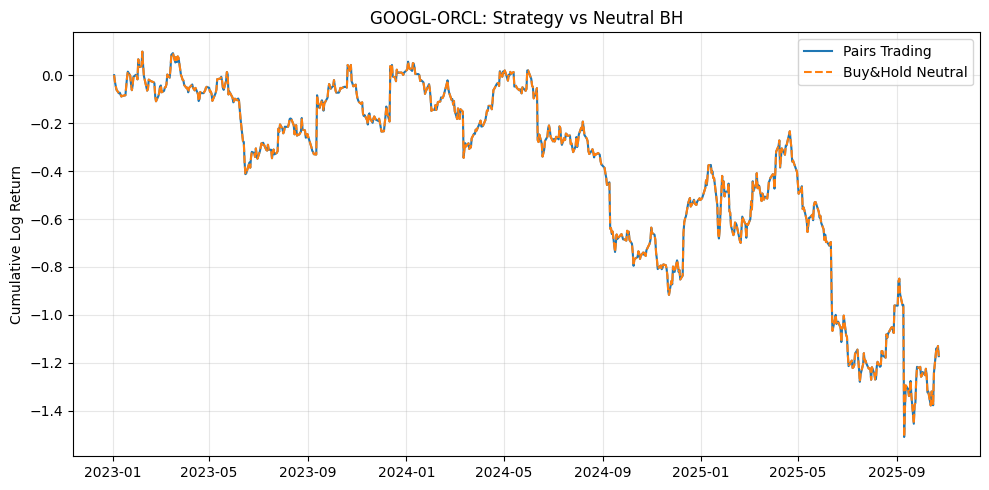

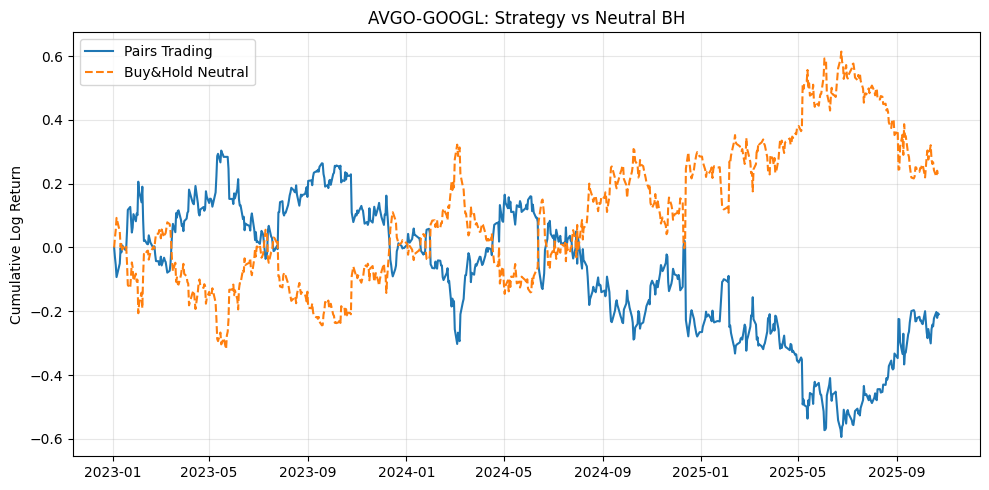

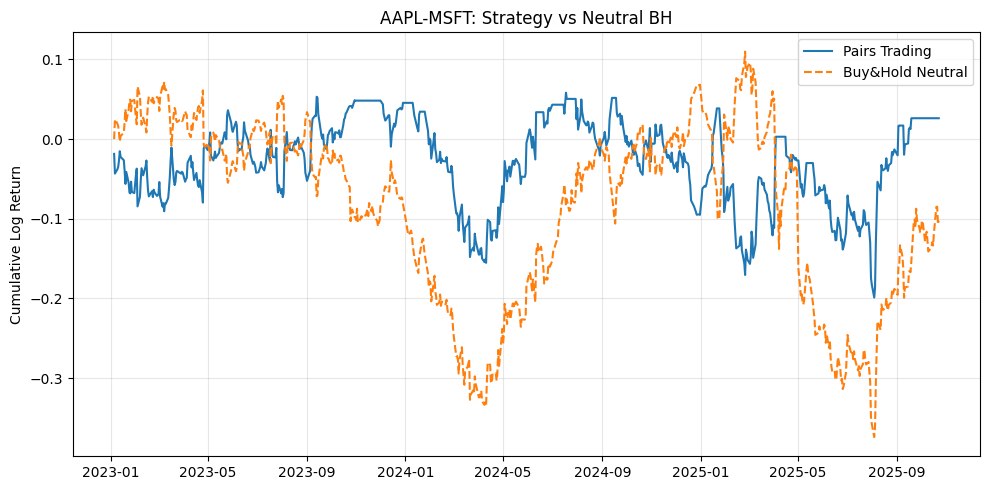

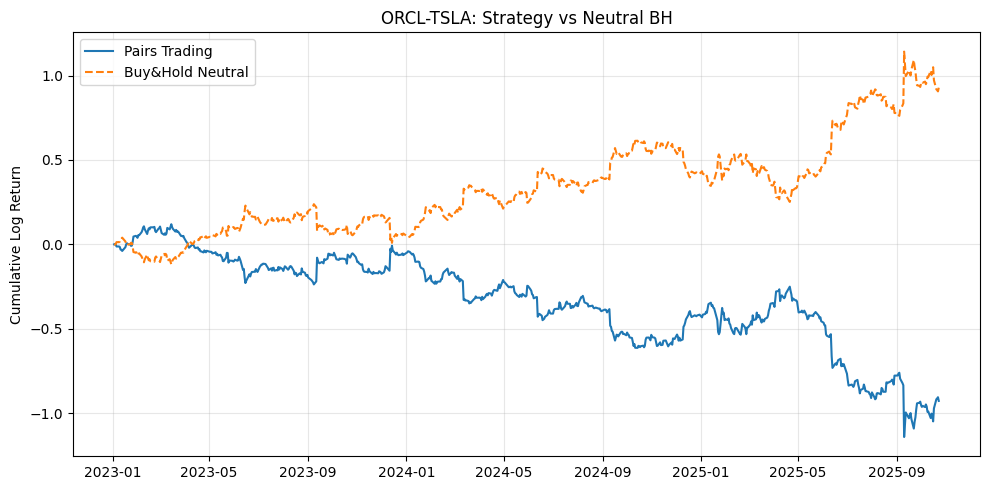

== Strategy vs Neutral Buy&Hold (aligned)==


,Strat_CumRet,Strat_AnnRet,Strat_AnnVol,Strat_Sharpe,Strat_MaxDD,Strat_WinRt,BH_CumRet,BH_AnnRet,BH_AnnVol,BH_Sharpe,BH_MaxDD,BH_WinRt,Days
Pair,,,,,,,,,,,,,
GOOGL-ORCL,-0.6903,-0.3423,0.7186,-0.5831,-0.7997,0.4865,-0.6903,-0.3423,0.7186,-0.5831,-0.7997,0.4865,705
AVGO-GOOGL,-0.1888,-0.0721,0.5270,-0.1419,-0.5927,0.4894,0.2574,0.0853,0.5281,0.1551,-0.3737,0.5078,705
AAPL-MSFT,0.0265,0.0094,0.2166,0.0433,-0.2267,0.4139,-0.0974,-0.0361,0.2428,-0.1513,-0.3835,0.5050,703
ORCL-TSLA,-0.6047,-0.2824,0.4007,-0.8280,-0.7167,0.4567,1.5299,0.3934,0.4007,0.8280,-0.3042,0.5418,705


== Excess (Strategy - BH-Neutral) ==


,Excess_AnnRet,Excess_Sharpe,Excess_CumRet
Pair,,,
GOOGL-ORCL,0.0000,0.0000,0.0000
AVGO-GOOGL,-0.1574,-0.2970,-0.4462
AAPL-MSFT,0.0455,0.1946,0.1239
ORCL-TSLA,-0.6758,-1.6559,-2.1347


In [32]:
pairs_to_use = [
    ('GOOGL', 'ORCL'),
    ('AVGO', 'GOOGL'),
    ("AAPL", "MSFT"),
    ('ORCL', 'TSLA')
]

results = {}
benchmarks = {}
metrics_rows = []          
excess_rows = []         

for s1, s2 in pairs_to_use:
    match = pair_df[(pair_df["stock1"] == s1) & (pair_df["stock2"] == s2)]
    if match.empty:
        print(f"Pair ({s1}, {s2}) not found in pair_df, skipped.")
        continue

    row = match.iloc[0]
    key = (s1, s2)
    
    res = backtest_pair(predicted, close, row)
    results[key] = res
    # plot_pair_performance(res, row)

    first_trade_date = res.loc[(res["pos_" + s1] != 0) | (res["pos_" + s2] != 0)].index[0]
    close["Date"] = pd.to_datetime(close["Date"])
    actual_window = close.loc[close["Date"] >= first_trade_date, ["Date", s1, s2]]


    bh = buyhold_benchmark_neutral(actual_window, row)
    idx = res.index.intersection(bh.index)
    bh_aligned = bh.loc[idx].copy()
    res_aligned = res.loc[idx].copy()
    benchmarks[key] = bh_aligned
    
    plot_strategy_vs_benchmark(res_aligned, bh_aligned, title=f"{s1}-{s2}: Strategy vs Neutral BH")

    #compute_pair_metrics
    m_strat = compute_pair_metrics(res_aligned)
    m_bh    = compute_pair_metrics(bh_aligned)

    metrics_rows.append({
        "Pair": f"{s1}-{s2}",
        # strategy
        "Strat_CumRet": m_strat["CumulativeReturn"],
        "Strat_AnnRet": m_strat["AnnualizedReturn"],
        "Strat_AnnVol": m_strat["AnnualVolatility"],
        "Strat_Sharpe": m_strat["SharpeRatio"],
        "Strat_MaxDD" : m_strat["MaxDrawdown"],
        "Strat_WinRt" : m_strat["WinRate"],
        # benchmark
        "BH_CumRet": m_bh["CumulativeReturn"],
        "BH_AnnRet": m_bh["AnnualizedReturn"],
        "BH_AnnVol": m_bh["AnnualVolatility"],
        "BH_Sharpe": m_bh["SharpeRatio"],
        "BH_MaxDD" : m_bh["MaxDrawdown"],
        "BH_WinRt" : m_bh["WinRate"],
        "Days": m_strat["Days"]
    })

    excess_rows.append({
        "Pair": f"{s1}-{s2}",
        "Excess_AnnRet": (m_strat["AnnualizedReturn"] - m_bh["AnnualizedReturn"]),
        "Excess_Sharpe": (m_strat["SharpeRatio"] - m_bh["SharpeRatio"]),
        "Excess_CumRet": (m_strat["CumulativeReturn"] - m_bh["CumulativeReturn"]),
    })

df_metrics = pd.DataFrame(metrics_rows).set_index("Pair")
df_excess  = pd.DataFrame(excess_rows).set_index("Pair")


print("== Strategy vs Neutral Buy&Hold (aligned)==")
display(df_metrics.round(4))

print("== Excess (Strategy - BH-Neutral) ==")
display(df_excess.round(4))